# Train a shallow SNN on the Randman Dataset

In [1]:
import sys

sys.path.append("../")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns
from spiffyplots import MultiPanel

from stork.datasets import make_coRandman, RasDataset, split_dataset
from stork.activations import SuperSpike
from stork.regularizers import LowerBoundL2, UpperBoundL2
from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, LIFGroup, DeltaSynapseLIFGroup
from stork.connections import Connection, SuperConnection
from stork.generators import StandardGenerator
from stork.initializers import KaimingNormalInitializer
from stork.monitors import SpikeCountMonitor, StateMonitor
from stork.optimizers import SMORMS3
from stork.loss_stacks import MaxOverTimeCrossEntropy
from stork.plotting import plot_activity_snapshot

from datetime import datetime

import wandb

## Generate Dataset

Specify the Dataset Parameters

In [2]:
# dataset parameters
dim_manifold = 1
nb_sub_classes = 5
nb_classes = nb_sub_classes**2
nb_inputs = 20

nb_time_steps = 180
T_delay = 0
sample_duration = 30


nb_samples = 200
nb_spikes = 1
alpha = 1
randmanseed = 1
dt = 2e-3

duration = nb_time_steps * dt


# Model Parameters
batch_size = 3000
beta = 20
device = torch.device("cuda:1")
dtype = torch.float


nb_hidden_units = 128
tau_mem = 20e-3
tau_syn = 10e-3
tau_readout = 40e-3

tau_filter = 20e-3
nb_filters = 10

lr = 5e-3
nb_epochs = 100

# regularizer parameters
lowerBoundL2Strength = 100
lowerBoundL2Threshold = 1e-3
upperBoundL2Strength = 0.1
upperBoundL2Threshold = (
    4  # Regularizes spikecount: 4 spikes ~ 20 Hz in 200ms simulation time
)

# Initializer parameters
sigma_u = 1.0
nu = nb_spikes / duration
gain = 15


# seeds
seed = 246
np.random.seed(seed)
torch.manual_seed(seed)


dt_format = "%Y-%m-%d_%H:%M:%S"



In [3]:

config = {
    "dataset.dim_mainfold": dim_manifold,
    "dataset.nb_sub_classes": nb_sub_classes,
    "dataset.nb_classes": nb_classes,
    "dataset.nb_inputs": nb_inputs,
    "dataset.nb_time_steps": nb_time_steps,
    "dataset.T_delay": T_delay,
    "dataset.sample_duration": sample_duration,
    "dataset.nb_samples": nb_samples,
    "dataset.nb_spikes": nb_spikes,
    "dataset.alpha": alpha,
    "dataset.randmanseed": randmanseed,
    "dataset.dt": dt,
    "dataset.duration": duration,
    "model.batch_size": batch_size,
    "model.beta": beta,
    "model.device": device,
    "model.dtype": dtype,
    "model.nb_hidden_units": nb_hidden_units,
    "model.tau_mem": tau_mem,
    "model.tau_syn": tau_syn,
    "model.tau_readout": tau_readout,
    "model.tau_filter": tau_filter,
    "model.nb_filters": nb_filters,
    "model.lr": lr,
    "model.nb_epochs": nb_epochs,
    "regularizer.lowerBoundL2Strength": lowerBoundL2Strength,
    "regularizer.lowerBoundL2Threshold": lowerBoundL2Threshold,
    "regularizer.upperBoundL2Strength": upperBoundL2Strength,
    "regularizer.upperBoundL2Threshold": upperBoundL2Threshold,
    "initializer.sigma_u": sigma_u,
    "initializer.nu": nu,
    "initializer.gain": gain,
    "seed": seed,
}

In [4]:
wandbrun = wandb.init(
    project="CoRandman-Task",
    entity="snn-delay",
    config=config,
    name="testruns_" + datetime.now().strftime(dt_format),
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: jgygax (snn-delay). Use `wandb login --relogin` to force relogin


## Create delay task

In [5]:
data, labels = make_coRandman(
    dim_manifold=dim_manifold,
    nb_classes=nb_sub_classes,
    nb_units=nb_inputs,
    nb_steps=nb_time_steps,
    step_frac=sample_duration / nb_time_steps,
    nb_samples=nb_samples,
    nb_spikes=nb_spikes,
    alpha=alpha,
    seed=randmanseed,
    T_delay=T_delay + sample_duration,
)

In [6]:
ds_kwargs = dict(nb_steps=nb_time_steps, nb_units=nb_inputs, time_scale=1.0)

# Split into train, test and validation set
datasets = [
    RasDataset(ds, **ds_kwargs)
    for ds in split_dataset(data, labels, splits=[0.8, 0.1, 0.1], shuffle=False)
]
ds_train, ds_valid, ds_test = datasets

In [7]:
print(len(ds_train))

800000


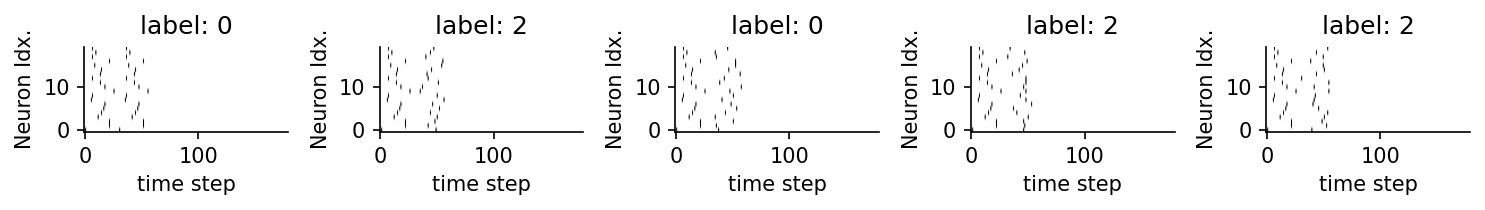

In [8]:
fig, ax = plt.subplots(1, 5, figsize=(10, 1.5), dpi=150)
for i in range(5):
    ax[i].imshow(np.transpose(ds_train[i][0]), cmap="binary", aspect="auto")
    ax[i].invert_yaxis()
    ax[i].set_xlabel("time step")
    ax[i].set_ylabel("Neuron Idx.")
    ax[i].set_title("label: " + str(ds_train[i][1]))

plt.tight_layout()
sns.despine()

## Set up the model

In [9]:
act_fn = SuperSpike
act_fn.beta = beta
neuron_group = LIFGroup

model = RecurrentSpikingModel(batch_size, nb_time_steps, nb_inputs, device, dtype)

Add neuron groups

In [10]:
input_group = model.add_group(InputGroup(nb_inputs))
hidden_neurons = model.add_group(
    DeltaSynapseLIFGroup(
        nb_hidden_units,
        tau_mem=tau_mem,
        # tau_syn=tau_syn,
        activation=act_fn,
    )
)
readout_group = model.add_group(
    ReadoutGroup(nb_classes, tau_mem=tau_readout, tau_syn=tau_syn, initial_state=-1e-2)
)

Add synapses between the neuron groups

In [11]:
con = model.add_connection(
    SuperConnection(
        input_group, hidden_neurons, tau_filter=tau_filter, nb_filters=nb_filters
    )
)
con_ro = model.add_connection(Connection(hidden_neurons, readout_group))

Add regularizers

In [12]:
# Define regularizer list
regs = []

regLB = LowerBoundL2(lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False)
regs.append(regLB)
regUB = UpperBoundL2(upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=1)
regs.append(regUB)

# Add to neurons
hidden_neurons.regularizers.extend(regs)

We initialize the network in the Flucutation-Driven regime, with a target membrane potential standard deviation $\sigma_U=1.0$

In [13]:
initializer = KaimingNormalInitializer(gain=gain)

con.init_parameters(initializer=initializer)
con_ro.init_parameters(initializer=initializer)

Add monitors for spikes and membrane potential

In [14]:
print(model.groups[1])

DeltaSynapseLIFGroup()


In [15]:
# model.add_monitor(SpikeCountMonitor(model.groups[1]))
model.add_monitor(StateMonitor(model.groups[1], "out"))

Choose loss function (We chose a maximum over time crossentropy loss, where the class is chosen according to the readout neuron that has the highest membrane potential over the simulation time)

In [16]:
loss_stack = MaxOverTimeCrossEntropy()

We select the SMORMS3 optimizer

In [17]:
opt = SMORMS3
generator = StandardGenerator(nb_workers=2)

In [18]:
model.configure(
    input=input_group,
    output=readout_group,
    loss_stack=loss_stack,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=dict(lr=lr),
    time_step=dt,
    wandb=wandbrun,
)

Before we train the model, we monitor the spikes

In [19]:
# Monitors spike counts before training
res = model.monitor(ds_test)
results = {}

In [20]:
# total_spikes = torch.sum(res[0]).item()
# total_spikes_per_layer = [torch.sum(res[i]).item() for i in range(1)]
# results["avg_layer_freq_init"] = [
#     nb / len(ds_test) / duration / nb_hidden_units for nb in total_spikes_per_layer
# ]

# print(results)

In [21]:
before_pop_fr = torch.mean(res[0], dim=(2))
before_mean_pop_fr = torch.mean(before_pop_fr, dim=(0))
before_std_pop_fr = torch.std(before_pop_fr, dim=(0))

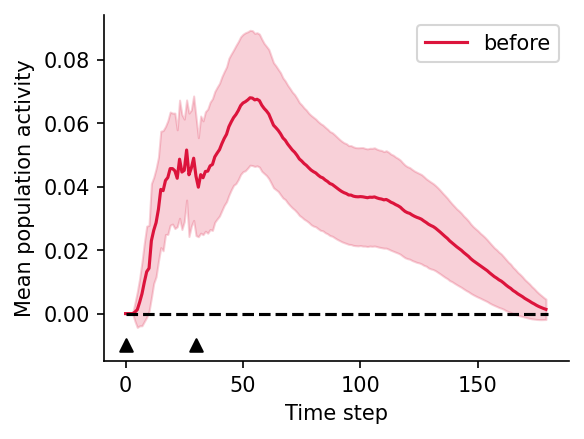

In [22]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(before_mean_pop_fr, color="crimson", label="before")
plt.fill_between(
    np.arange(before_mean_pop_fr.shape[0]),
    before_mean_pop_fr - before_std_pop_fr,
    before_mean_pop_fr + before_std_pop_fr,
    color="crimson",
    alpha=0.2,
)


plt.hlines(0, 0, before_mean_pop_fr.shape[0], linestyle="--", color="black")


plt.scatter([0, sample_duration + T_delay], [-0.01, -0.01], color="black", marker="^")

plt.xlabel("Time step")
plt.ylabel("Mean population activity")
plt.legend(loc="upper right")
sns.despine()

In [23]:
before_weighted_filters = model.connections[0].get_filterbanks(T=duration)

# shape = (time, n_post, n_pre, nb_filters, kernel_size)
print(before_weighted_filters.shape)

# Sum over filter axis
before_weighted_filters_sum = before_weighted_filters.sum(axis=3)

(181, 128, 20, 10)


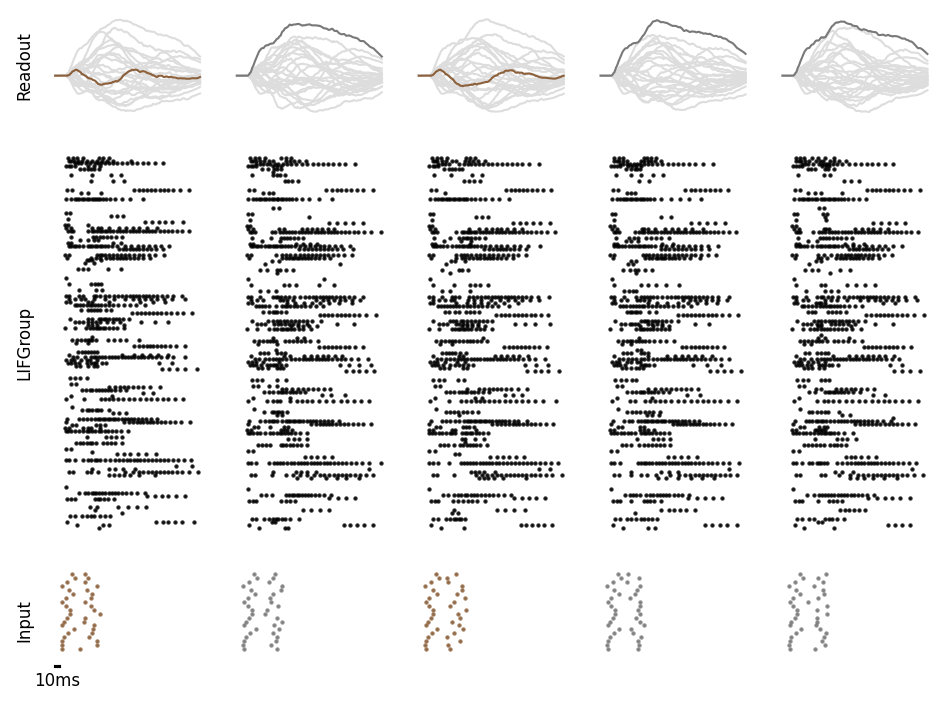

In [24]:
plt.figure(dpi=150)
plot_activity_snapshot(model, data=ds_test, point_alpha=0.8, show_predictions=False)

## Training


In [25]:
history = model.fit_validate(ds_train, ds_valid, nb_epochs=nb_epochs, verbose=True)

results["train_loss"] = history["loss"].tolist()
results["train_acc"] = history["acc"].tolist()
results["valid_loss"] = history["val_loss"].tolist()
results["valid_acc"] = history["val_acc"].tolist()

00  loss=2.97 reg_loss=0.0154 acc=0.182 -- val_loss=2.36 val_reg_loss=0.00436 val_acc=0.288 t_iter=55.22
01  loss=1.94 reg_loss=0.00478 acc=0.392 -- val_loss=1.79 val_reg_loss=0.00334 val_acc=0.438 t_iter=57.45
02  loss=1.49 reg_loss=0.00356 acc=0.53 -- val_loss=1.48 val_reg_loss=0.00224 val_acc=0.523 t_iter=56.56
03  loss=1.19 reg_loss=0.0027 acc=0.622 -- val_loss=1.22 val_reg_loss=0.00225 val_acc=0.601 t_iter=58.93
04  loss=0.968 reg_loss=0.00242 acc=0.692 -- val_loss=1.02 val_reg_loss=0.00197 val_acc=0.665 t_iter=58.30
05  loss=0.799 reg_loss=0.00215 acc=0.748 -- val_loss=0.882 val_reg_loss=0.00179 val_acc=0.707 t_iter=58.56
06  loss=0.667 reg_loss=0.00205 acc=0.791 -- val_loss=0.771 val_reg_loss=0.00172 val_acc=0.739 t_iter=59.14
07  loss=0.559 reg_loss=0.00202 acc=0.826 -- val_loss=0.668 val_reg_loss=0.00187 val_acc=0.774 t_iter=63.36
08  loss=0.474 reg_loss=0.00198 acc=0.854 -- val_loss=0.576 val_reg_loss=0.00159 val_acc=0.807 t_iter=59.17


#### Monitor the model again after training

In [ ]:
res = model.monitor(ds_test)

In [ ]:
# total_spikes_per_layer = [torch.sum(res[i]).item() for i in range(1)]
# results["avg_layer_freq"] = [
#     nb / len(ds_test) / duration / nb_hidden_units for nb in total_spikes_per_layer
# ]

In [ ]:
after_pop_fr = torch.mean(res[0], dim=(2))
after_mean_pop_fr = torch.mean(after_pop_fr, dim=(0))
after_std_pop_fr = torch.std(after_pop_fr, dim=(0))

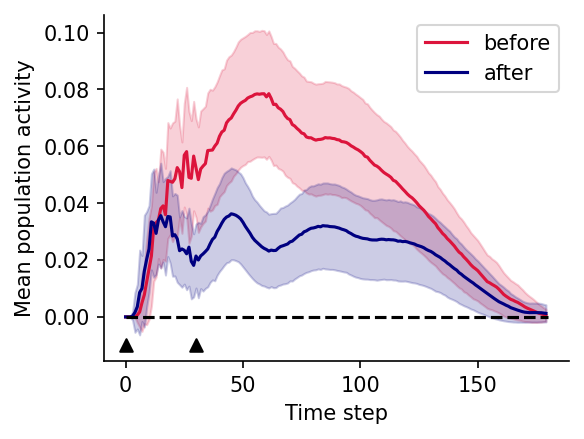

In [ ]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(before_mean_pop_fr, color="crimson", label="before")
plt.fill_between(
    np.arange(before_mean_pop_fr.shape[0]),
    before_mean_pop_fr - before_std_pop_fr,
    before_mean_pop_fr + before_std_pop_fr,
    color="crimson",
    alpha=0.2,
)


plt.plot(after_mean_pop_fr, color="navy", label="after")
plt.fill_between(
    np.arange(after_mean_pop_fr.shape[0]),
    after_mean_pop_fr - after_std_pop_fr,
    after_mean_pop_fr + after_std_pop_fr,
    color="navy",
    alpha=0.2,
)

plt.hlines(0, 0, after_mean_pop_fr.shape[0], linestyle="--", color="black")


plt.scatter([0, sample_duration + T_delay], [-0.01, -0.01], color="black", marker="^")

plt.xlabel("Time step")
plt.ylabel("Mean population activity")
plt.legend(loc="upper right")
sns.despine()

## Test

In [ ]:
scores = model.evaluate(ds_test).tolist()
results["test_loss"], _, results["test_acc"] = scores

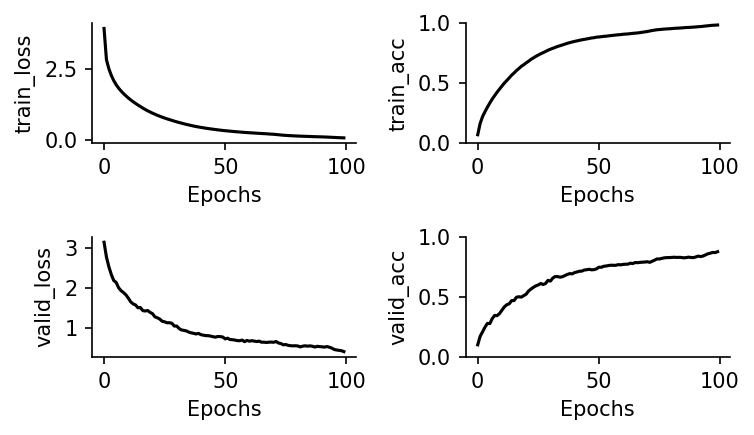

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(5, 3), dpi=150)

for i, n in enumerate(["train_loss", "train_acc", "valid_loss", "valid_acc"]):

    if i < 2:
        a = ax[0][i]
    else:
        a = ax[1][i - 2]

    a.plot(results[n], color="black")
    a.set_xlabel("Epochs")
    a.set_ylabel(n)

ax[0, 1].set_ylim(0, 1)
ax[1, 1].set_ylim(0, 1)

sns.despine()
plt.tight_layout()

In [ ]:
print("Test loss: ", results["test_loss"])
print("Test acc.: ", round(results["test_acc"] * 100, 2), "%")


print("Valid loss: ", results["valid_loss"])
print("Valid acc.: ", round(results["valid_acc"][-1] * 100, 2), "%")

Test loss:  0.4137258099185096
Test acc.:  87.76 %
Valid loss:  [3.140634404288398, 2.7714048756493463, 2.527733670340644, 2.3367239899105496, 2.1874558793173895, 2.1402835845947266, 2.009149922264947, 1.9353621668285794, 1.889986925654941, 1.8324147860209148, 1.751458724339803, 1.6564288271798029, 1.605111175113254, 1.5791055493884616, 1.508969744046529, 1.5145826604631212, 1.4377039935853746, 1.4284947845670912, 1.4410546488232083, 1.3939889272054036, 1.3622812959882948, 1.2826687296231587, 1.2600181102752686, 1.227280080318451, 1.172867668999566, 1.1597177849875555, 1.13528178135554, 1.1368886563513014, 1.123139460881551, 1.0538948443200853, 1.0539171563254461, 0.9918308721648322, 0.9554817279179891, 0.9457128975126479, 0.9322678446769714, 0.9032404157850478, 0.8839818702803718, 0.8727117114596896, 0.8566226561864217, 0.8713892665174272, 0.8395750357045068, 0.8265190223852793, 0.8158116042613983, 0.814382983578576, 0.8036233054267036, 0.7883932027551863, 0.7776834136909909, 0.795096

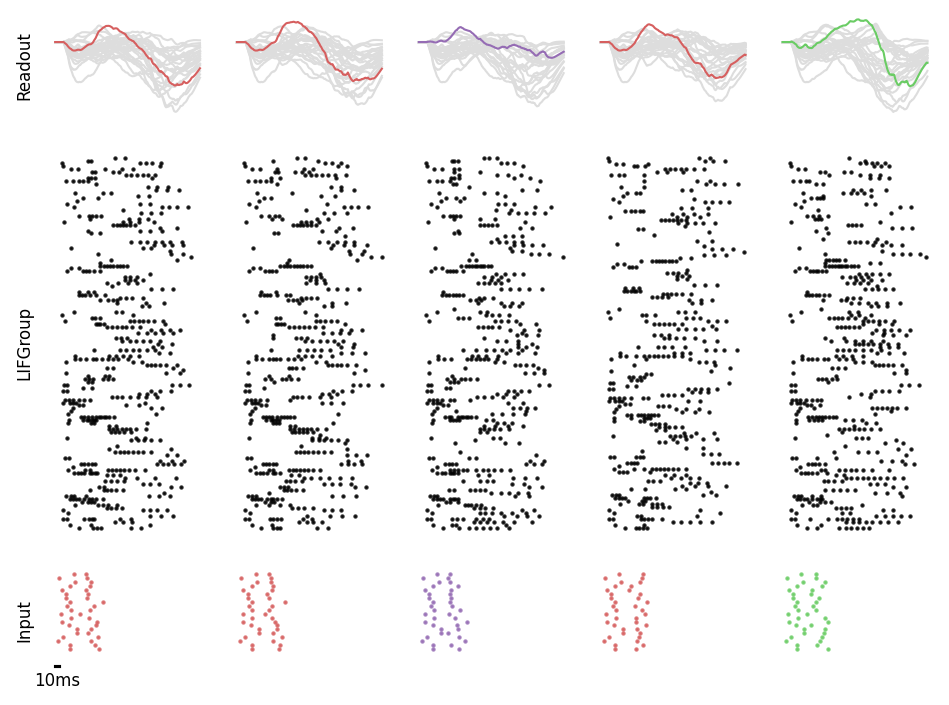

In [ ]:
plt.figure(dpi=150)
plot_activity_snapshot(
    model, data=ds_test, point_alpha=0.8, show_predictions=False, nb_samples=5
)

In [ ]:
after_weighted_filters = model.connections[0].get_filterbanks(T=duration)

# shape = (time, n_post, n_pre, nb_filters, kernel_size)
print(after_weighted_filters.shape)

# Sum over filter axis
after_weighted_filters_sum = after_weighted_filters.sum(axis=3)

print(after_weighted_filters_sum.shape)

(181, 128, 20, 10)
(181, 128, 20)


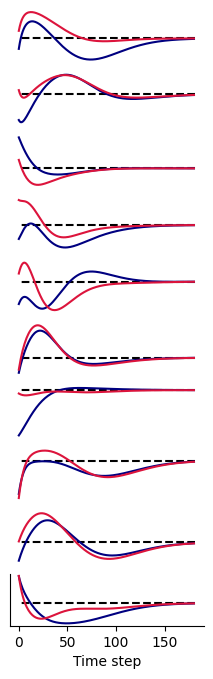

In [ ]:
fig = MultiPanel(
    grid=[1] * 10, figsize=(2.5, 8), dpi=150, sharey=True, sharex=True
)  # TODO: sharex and sharey don't do anything...

for idx in range(10):
    fig.panels[idx].hlines(
        0, after_weighted_filters_sum.shape[0], 0, color="black", linestyle="--"
    )
    fig.panels[idx].plot(after_weighted_filters_sum[:, idx, 0], color="navy")
    fig.panels[idx].plot(before_weighted_filters_sum[:, idx, 0], color="crimson")

    if idx < 9:
        fig.panels[idx].axis("off")
    else:
        fig.panels[idx].set_xlabel("Time step")
        fig.panels[idx].set_yticks([])
        fig.panels[idx].spines["left"].set_visible(False)
sns.despine()

In [ ]:
wandbrun.finish()